Rigetti Computing Proprietary & Confidential and Copyright Rigetti Computing 2021-2012.

In [ ]:
using Pkg
Pkg.activate("./")

In [48]:
using QSimulator 
using Optim
using LsqFit
# using ProgressMeter
# using JLD
using NLsolve
using Roots
using QuadGK
using PyPlot
using LinearAlgebra
using Interpolations
using FFTW
using SpecialFunctions
import Statistics

import QuantumInfo: liou, avgfidelity, kraus2liou # open-source package
import Cliffords: Z
using Optim
using LinearAlgebra: diagm

In [49]:
function transmonEJECratio(fmax,fmin,etamax)
    """Calculate the transmon EJ,EC and the ratio r =EJ1/EJ2
    params:
        fmax    qubit f01 at zero flux in GHz
        fmin    qubit f01 at 1/f flux quantum in GHz
        etamax  qubit anharmonicity (positive) at zero flux in GHz
    return:
        Ej      total SQUID junction energy in GHz
        Ec      charging energy in GHz
        r=EJ1/EJ2
    """
    function f!(F, x)
        F[1] = x[1]*(4.0/x[2] - (1.0 + x[2]/4.0 + 21.0*x[2]^2/128.0 + 19.0*x[2]^3/128.0))-fmax
        F[2] = x[1]*(1.0 + 9.0*x[2]/16.0 + 81.0*x[2]^2/128.0 + 3645.0*x[2]^3/4096.0)-etamax
    end

    function j!(J, x)
         J[1, 1] = 4.0/x[2]- (1.0 + x[2]/4.0 + 21.0*x[2]^2/128.0 + 19.0*x[2]^3/128.0)
         J[1, 2] = x[1]*(-4.0/x[2]^2-(1/4.0 + 42.0*x[2]/128.0 + 3.0*19.0*x[2]^2/128.0))
         J[2, 1] = 1.0 + 9.0*x[2]/16.0 + 81.0*x[2]^2/128.0 + 3645.0*x[2]^3/4096.0
         J[2, 2] = x[1]*(9.0/16.0 + 2.0*81.0*x[2]/128.0 + 3*3645.0*x[2]^2/4096.0)
    end
    res = nlsolve(f!, j!, [ .1; 0.1])
    Ec, xi_plus = res.zero
    Ej = 2*Ec/xi_plus^2
    function fun(x)
        Ec*(4.0/x-(1.0+x/4.0+21.0*x^2/128.0+19.0*x^3/128.0))-fmin
    end
    sol2 = fzero(fun, 0, Inf)
    xi_minus = (sol2/xi_plus)^4
    function fun_ratio(y)
        xi_minus-(1+y)^2/(y-1)^2
    end
    ratio = fzero(fun_ratio,1.,10) 
    return Ej,Ec,ratio
end

transmonEJECratio (generic function with 1 method)

In [50]:
function transmonEJ1EJ2EC(fmax,fmin,etamax)

    function f!(F, x)
        F[1] = x[1]*(4.0/x[2] - (1.0 + x[2]/4.0 + 21.0*x[2]^2/128.0 + 19.0*x[2]^3/128.0))-fmax
        F[2] = x[1]*(1.0 + 9.0*x[2]/16.0 + 81.0*x[2]^2/128.0 + 3645.0*x[2]^3/4096.0)-etamax
    end

    function j!(J, x)
         J[1, 1] = 4.0/x[2]- (1.0 + x[2]/4.0 + 21.0*x[2]^2/128.0 + 19.0*x[2]^3/128.0)
         J[1, 2] = x[1]*(-4.0/x[2]^2-(1/4.0 + 42.0*x[2]/128.0 + 3.0*19.0*x[2]^2/128.0))
         J[2, 1] = 1.0 + 9.0*x[2]/16.0 + 81.0*x[2]^2/128.0 + 3645.0*x[2]^3/4096.0
         J[2, 2] = x[1]*(9.0/16.0 + 2.0*81.0*x[2]/128.0 + 3*3645.0*x[2]^2/4096.0)
    end
    res = nlsolve(f!, j!, [ .1; 0.1])
    Ec, xi_plus = res.zero
    Ej = 2*Ec/xi_plus^2
    function fun(x)
        Ec*(4.0/x-(1.0+x/4.0+21.0*x^2/128.0+19.0*x^3/128.0))-fmin
    end
    sol2 = fzero(fun, 0, Inf)
    xi_minus = (sol2/xi_plus)^4
    function fun_ratio(y)
        xi_minus-(1+y)^2/(y-1)^2
    end
    ratio = fzero(fun_ratio,1.,10) 
    EJ1 = Ej/(1+ratio)
    EJ2 = ratio*EJ1
    return EJ1,EJ2,Ec
end

transmonEJ1EJ2EC (generic function with 1 method)

In [51]:
function average_frequency(fmax, fmin, etamax, phipark, phim, omegam, f01f, etaf)
    """
    Computes the frequency of asymmetric transmon as function of time
    paramp: 
        EJ     total energy of the SQUID junction EJ = EJ1+EJ2
        EC     charging energy 
        r      ratio junction energy r = EJ1/EJ2
        phip   dc parking flux bias 
        phim   flux modulation amplitude 
        omegam flux modulation frequency
    return:
        func       average frequency of the qubit
        df01       frequency shift during modulation
        CZ02_1st   modulation frequency for CZ02 gate 1st harmonic
        CZ20_1st   modulation frequency for CZ20 gate 1st harmonic
        iSWAP_1st  modulation frequency for iSWAP gate 1st harmonic
    """
    EJ, EC, r =  transmonEJECratio(fmax,fmin,etamax)
    xi = sqrt(2*EC/EJ)
    T = 2*pi/omegam
    function fn(t)
        flux = phipark + phim* sin.(omegam*t/2)
        norm = sqrt(1+r^2+2*r*cos(2*pi*flux))/(r+1)
        freq = sqrt(8*EJ*EC*norm)-EC*(1+xi /(4*norm)+21*xi^2 /(128*norm^2)+19*xi^3 /(128*norm.^3))
        return freq
    end
    function anharm(t)
        flux = phipark + phim* sin.(omegam*t/2)
        norm = sqrt(1+r^2+2*r*cos(2*pi*flux))/(r+1)
        anh = EC*(1+9*xi/(16*norm) + 81*xi^2 /(128*norm.^2) + 3645*xi^3 /(4096*norm^3))
        return anh
    end
    func = quadgk(fn,0.0,T)[1]/T
    etaave = quadgk(anharm,0.0,T)[1]/T
    df01 = fmax - func
    CZ02_1st = (func - etaave - f01f)/2.0
    CZ20_1st = (func - f01f + etaf)/2.0
    iSWAP_1st = (func - f01f)/2.0

    return [func,CZ02_1st,CZ20_1st,iSWAP_1st,etaave]
end

average_frequency (generic function with 1 method)

In [52]:
function RabiModel(x::Array{Float64,1}, p::Array{Float64,1})
    """
    Fit function used for Rabi oscillation to extract effective coupling
    params:
        p[2] effective coupling g_eff in MHz
        p[3] phase
        p[1] amplitude of Rabi oscillation
    """
    p[1]*cos.(2π * p[2] .* x ).^2 .+ p[3]
end

RabiModel (generic function with 1 method)

In [53]:
function infidelity(U_final,U_ideal,θ)
    """
    Define process fidleity and optimize over single qubit rotations.
    params:
        U_final  noise process matrix from the simulation
        U_ideal  the ideal process matrix for the target get
        θ  the initial guess for the single qubit rotation angles
    returns:
        res infidelity
    """
        function gate_optimize(θ)
            single_qubit_rotation = exp(-1im * ((θ[1]/2.0 * σ1z) + (θ[2]/2.0 * σ2z)))
            U_corrected = single_qubit_rotation*U_ideal
            UU = conj(U_corrected)⊗U_corrected
            1-real((tr(UU'*U_final)+4.0))/(16.0+4.0)
        end 
        res = optimize(gate_optimize,θ).minimum
        return res
end

infidelity (generic function with 1 method)

In [54]:
function erfsquare_with_pads(tramp,tf,pad_length,t)
    """
    Error function square pulse
    
    :param tramp:       rise and fall time of the pulse.
    :param tf:          length of the flux pulse (without pads).
    :paramp pad_length: length of pad to be added on each side of the pulse.
    : return errfun:    error function square pulse.
    """
    fwhm = 0.5*tramp
    σ = fwhm/(2.0*sqrt(2.0 *log(2.0)))
    errfun = 0.5*(erf((t -pad_length- tramp)/σ)-erf((t + tramp - pad_length - tf)/σ))
    if t <= pad_length
        return  0
    elseif pad_length <= t <= tf+pad_length 
        return errfun
    elseif tf+pad_length  < t <= tf + 2*pad_length
    return 0
    end
end

erfsquare_with_pads (generic function with 1 method)

## Parameters and unitaries

In [55]:
#define operators
σ0 = [0.0 1.0 0.0;0.0 0.0 √2.0;0.0 0.0 0.0]    
σz = σ0'*σ0
σ1z = [-1.0 0.0;0.0 1.0]⊗ Matrix(I,2,2)
σ2z =  Matrix(I,2,2)⊗[-1.0 0.0;0.0 1.0]
UiSWAP = [1.0 0.0 0.0 0.0 ;0.0 0.0 1im 0.0; 0.0 1im 0.0 0.0; 0.0 0.0 0.0 1.0]
UCZ = [1.0 0.0 0.0 0.0 ;0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 -1.0]
ln = [1 2 4 5 10 11 13 14 28 29 31 32 37 38 40 41] # indces of initial conditions
Iden = [1.0 0.0 0.0; 0.0 1.0 0.0]⊗[1.0 0.0 0.0; 0.0 1.0 0.0];

In [56]:
T1t = 13000.0 # in ns
Tphit = 7000.0  # in ns
T1f = 38000.0 # in ns
Tphif = 15000.0  # in ns
γ1t = 1/(2π * T1t)
γϕt = 1/(2π * Tphit)
γ1f = 1/(2π * T1f)
γϕf = 1/(2π * Tphif)

fmax, fmin, etamax = [5.272,4.383,0.197] # in GHz
f01_f, eta_f = [3.887,0.187] # in GHz
phipark = 0.0 # dc parking flux bias
g01 =  0.010 # from measurement
phim = 0.6 # in units of Phi0. AC sweet spot amplitude
ωm = 2π*0.3  #in GHz
ave_freq = average_frequency(fmax, fmin, etamax, phipark, phim, ωm, f01_f, eta_f);

# Resonance conditions

In [57]:
flux_mod = 0:0.01:1
CZ20 = [average_frequency.(fmax, fmin, etamax, phipark, k, ωm, f01_f, eta_f)[2] for k in flux_mod]
CZ02 = [average_frequency.(fmax, fmin, etamax, phipark, k, ωm, f01_f, eta_f)[3] for k in flux_mod]
iSWAP = [average_frequency.(fmax, fmin, etamax, phipark, k, ωm, f01_f, eta_f)[4] for k in flux_mod];

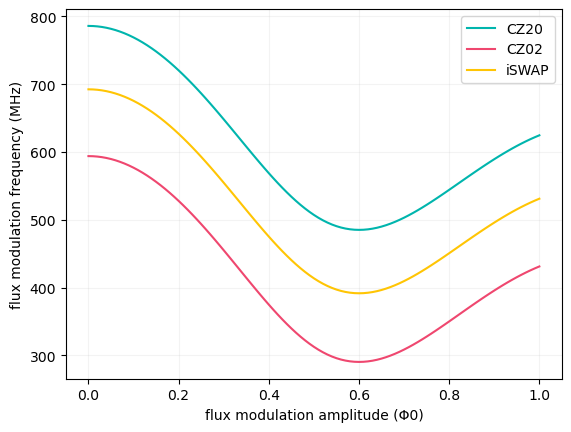

PyObject Text(24.000000000000007, 0.5, 'flux modulation frequency (MHz)')

In [58]:
clrs = ["#00B5AD", "#0D0D36", "#EF476F", "#FFC504","#3D47D9"] # 
plot(flux_mod,CZ02*1e3,label="CZ20",color=clrs[1])
plot(flux_mod,CZ20*1e3,label="CZ02",color=clrs[3])
plot(flux_mod,iSWAP*1e3,label="iSWAP",color=clrs[4])
legend()
grid(alpha=0.15)
xlabel("flux modulation amplitude (Φ0)")
ylabel("flux modulation frequency (MHz)")


## Find optimum modulation frequency  for CZs and iSWAP gates

In [59]:
tmax = 200.0 # in ns
times = collect(0.0:1:tmax)

ψ0CZ = ComplexF64[0.0; 1.0; 0.0]⊗ComplexF64[0.0; 1.0; 0.0] # initial condition for CZ
ψ0iSWAP = ComplexF64[0.0; 1.0; 0.0]⊗ComplexF64[1.0; 0.0; 0.0] # initial condition for iSWAP

EJ_small,EJ_large,Ec =  transmonEJ1EJ2EC(fmax,fmin,etamax) # get tunable transmon parameters using transmon model.
q1 = DuffingTransmon("q1", 3, DuffingSpec(f01_f, -eta_f) ) # define fixed-frequency transmon 
q0 = PerturbativeTransmon("q0", 3, TransmonSpec(Ec, EJ_large, EJ_small)) # define tunable transmon 


#find optimal modulation frequency for activating the gates around the initial value from the simulation
fm_opt_list_CZ = []
fm_opt_list_iSWAP = []

for l in 2:1:3
    omg_list = []
    rho_list = []

    for k in 1:1:10
        freq_mod = ave_freq[l] + 0.0005*(k-1)
        ρ11 = []
        cqs = CompositeQSystem([q0, q1]) #construct the composite system
        add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*sin(2π*freq_mod*t)), q0) # free Hamiltonian with variable frequency
        add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1]) # interaction Hamiltonian 
        add_hamiltonian!(cqs, q1) # qubit 1 free Hamiltonian 
        ψs = unitary_state(cqs, times, ψ0CZ);

        ρ11 = [abs2(s[5]) for s in ψs]
        push!(omg_list,freq_mod)
        push!(rho_list,minimum(ρ11))
    end
    idx = argmin(rho_list)
    fm_opt = round(omg_list[idx],digits=6)
    append!(fm_opt_list_CZ,fm_opt)
end


omg_list = []
rho_list = []

for k in 1:1:10
    freq_mod = ave_freq[4] + 0.0005*(k-1)
    ρ11 = []
    cqs = CompositeQSystem([q0, q1]) # construct the composite system
    add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*sin(2π*freq_mod*t)), q0)
    add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1])
    add_hamiltonian!(cqs, q1)
    ψs = unitary_state(cqs, times, ψ0iSWAP);

    ρ10 = [abs2(s[4]) for s in ψs]
    push!(omg_list,freq_mod)
    push!(rho_list,minimum(ρ10))
end
idx = argmin(rho_list)
fm_opt = round(omg_list[idx],digits=6)
append!(fm_opt_list_iSWAP,fm_opt)


1-element Array{Any,1}:
 0.392217

In [60]:
println("modulation frequency for CZ02 = ", round(fm_opt_list_CZ[1]*1000,digits=2), " MHz")
println("modulation frequency for CZ20 = ", round(fm_opt_list_CZ[2]*1000,digits=2), " MHz")
println("modulation frequency for iSWAP = ", round(fm_opt_list_iSWAP[1]*1000,digits=2), " MHz")

modulation frequency for CZ02 = 292.97 MHz
modulation frequency for CZ20 = 485.72 MHz
modulation frequency for iSWAP = 392.22 MHz


## Effective coupling: CZ 
The modulation renormalizes the bare qubit-qubit coupling by approximately the Bessel function of the first kind g-> gJ0. This coupling determines the gate time, for CZ, t_gate = pi/g

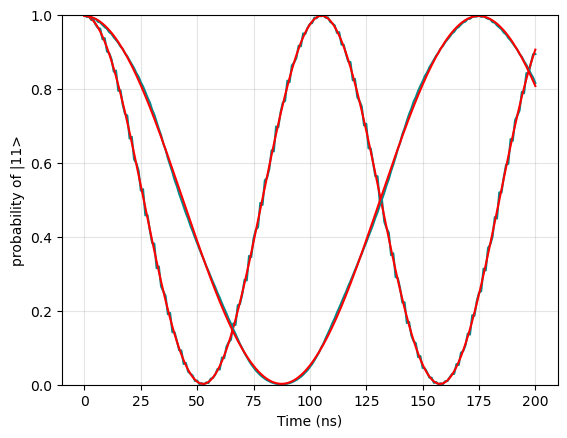

In [61]:
times = collect(0.0:1:tmax)
gatetime_CZ_optimal = []

for k in 1:1:2
    ρ11 = []
    ρ02 = []
    ρ20 = []
    cqs = CompositeQSystem([q0, q1])  # construct the composite system
    add_hamiltonian!(cqs, q1)
    add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*sin(2π*fm_opt_list_CZ[k]*t)), q0) # parametric drive or introducing modulation of qubit frequency.
    add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1])

    ψs = unitary_state(cqs, times, ψ0CZ);

    ρ11 = [abs2(s[5]) for s in ψs]
    ρ02 = [abs2(s[3]) for s in ψs]
    ρ20 = [abs2(s[7]) for s in ψs]

    p0 = [10.0,g01*0.4,0]
    p_fit = curve_fit(RabiModel, times, ρ11, p0).param
    gatetime_CZ = 1/(2*p_fit[2])

    plot(times, ρ11,color="darkcyan")
    plot(times, RabiModel(times, p_fit),linestyle="-",color ="red")
    grid(color="gray",alpha=0.2)
    xlabel("Time (ns)")
    ylabel("probability of |11>")
    ylim(0,1)
    append!(gatetime_CZ_optimal,gatetime_CZ)
end


## Effective coupling: iSWAP

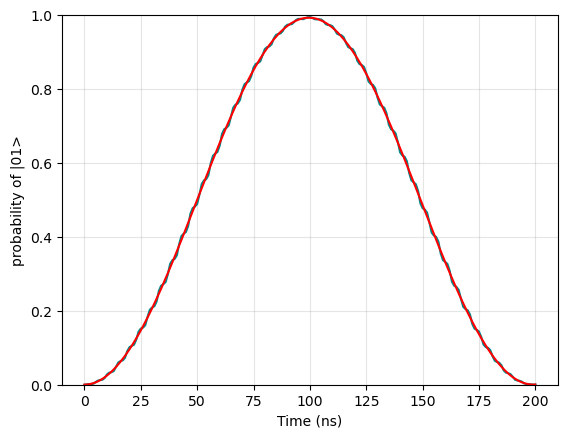

(0.0, 1.0)

In [62]:
ρ01 = []
ρ10 = []
cqs = CompositeQSystem([q0, q1])  # construct the composite system
add_hamiltonian!(cqs, q1)
add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*sin(2π*fm_opt_list_iSWAP[1]*t)), q0)
add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1])

ψs = unitary_state(cqs, times, ψ0iSWAP);

ρ01 = [abs2(s[2]) for s in ψs]
ρ10 = [abs2(s[4]) for s in ψs]

p0 = [10.0,g01*0.2,0] # initial guess 
p_fit = curve_fit(RabiModel, times, ρ01, p0).param
gatetime_iSWAP = 1/(4*p_fit[2])

plot(times, ρ01,color="darkcyan")
plot(times, RabiModel(times, p_fit),linestyle="-",color ="red")
grid(color="gray",alpha=0.2)
xlabel("Time (ns)")
ylabel("probability of |01>")
ylim(0,1)

## Flux pulse parameters and gate time

In [63]:
tramp = 8 # ramp time of the flux pulse
pad_length = 8 # padding on each side of the flux pulse 
tf = gatetime_CZ_optimal .+ 2*tramp
tf_with_pads = tf .+ 2*pad_length

tf_iswap = gatetime_iSWAP .+ 2*tramp
tf_iswap_with_pads = tf_iswap .+ 2*pad_length

131.52501134742295

## Fidelity of CZ with T1 and Tϕ

In [64]:
CZ_infidelity = []
for lm in 1:1:2  
    tff = tf[lm] 
    
    times = collect(0.0:1:tf_with_pads[lm])

    rho_final = []
    for k in 1:1:length(ln)
        IM = Matrix{ComplexF64}(I, 81,81)
        ρin = reshape(IM[:,ln[k]],9,9)

        cqs = CompositeQSystem([q0, q1]) # construct the composite system
        add_hamiltonian!(cqs, q1)
        add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*erfsquare_with_pads(tramp,tff,pad_length,t).*sin(2π*fm_opt_list_CZ[lm]*t)), q0)
        add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1])

        add_lindblad!(cqs, sqrt(γ1t)*σ0, [q0])
        add_lindblad!(cqs, sqrt(γϕt)*σz, [q0])
        add_lindblad!(cqs, sqrt(γ1f)*σ0, [q1])
        add_lindblad!(cqs, sqrt(γϕf)*σz, [q1])
        ρs = me_state(cqs, times, ρin);
        ρf = Iden*reshape(ρs[end],9,9)*Iden' # project on to the computational subspace
        append!(rho_final,   [reshape(ρf,16,1)])
    end
    UCZ = diagm(0 => [1.0,1.0,1.0,-1.0])
    final_process_matrix  = hcat([rho_final[l] for l=1:length(ln)]...)     # noisey process matrix
    push!(CZ_infidelity, infidelity(final_process_matrix,UCZ,zeros(2)))
end

In [65]:
println("Process fidelity of CZ02 = ", 100 .- round.(CZ_infidelity[1],digits=4)*100,"%",", gate time = ", round(tf_with_pads[1],digits=1)," ns")
println("Process fidelity of CZ20 = ", 100 .- round.(CZ_infidelity[2],digits=4)*100,"%",", gate time = ", round(tf_with_pads[2],digits=1)," ns")

Process fidelity of CZ02 = 98.22%, gate time = 137.2 ns
Process fidelity of CZ20 = 97.93%, gate time = 206.9 ns


## Fidelity of iSWAP with T1 and Tϕ

In [66]:
iSWAP_infidelity = []

times = collect(0.0:1:tf_iswap_with_pads)

rho_final = []
for k in 1:1:length(ln)
    IM = Matrix{ComplexF64}(I, 81,81)
    ρin = reshape(IM[:,ln[k]],9,9)

    cqs = CompositeQSystem([q0, q1]) # construct the composite system
    add_hamiltonian!(cqs, q1)
    add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*erfsquare_with_pads(tramp,tf_iswap[1],pad_length,t).*sin(2π*fm_opt_list_iSWAP[1]*t)), q0)
    add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1])

    add_lindblad!(cqs, sqrt(γ1t)*σ0, [q0])
    add_lindblad!(cqs, sqrt(γϕt)*σz, [q0])
    add_lindblad!(cqs, sqrt(γ1f)*σ0, [q1])
    add_lindblad!(cqs, sqrt(γϕf)*σz, [q1])
    ρs = me_state(cqs, times, ρin);
    ρf = Iden*reshape(ρs[end],9,9)*Iden' #project on to qubits subspace
    append!(rho_final,   [reshape(ρf,16,1)])
end
final_process_matrix  = hcat([rho_final[l] for l=1:length(ln)]...)     # noisey process matrix
iSWAP_infidelity= infidelity(final_process_matrix,UiSWAP,zeros(2))


0.015312574296349135

In [67]:
println("Process fidelity of iSWAP = ", 100 .- round.(iSWAP_infidelity[1],digits=4)*100,"%",", gate time = ", round(tf_iswap_with_pads[1],digits=1)," ns")

Process fidelity of iSWAP = 98.47%, gate time = 131.5 ns


## Fidelity of CZ without T1 and Tϕ

In [68]:
unitary_fidelity_CZ = []
for lm in 1:1:2
    cqs = CompositeQSystem([q0, q1]) # construct the composite system
    add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*erfsquare_with_pads(tramp,tf[lm],pad_length,t).*sin(2π*fm_opt_list_CZ[lm]*t)), q0)
    add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1])
    add_hamiltonian!(cqs, q1)
    U = unitary_propagator(cqs, float(tf_with_pads[lm]));
    # project out into the qubit space
    projector = [1,0]*[1, 0, 0]' + [0, 1]*[0, 1, 0]' 
    projector = projector ⊗ projector
    U_proj = projector * U * projector'
    import QuantumInfo: liou, avgfidelity, kraus2liou
    import Cliffords: Z
    using Optim
    using LinearAlgebra: diagm
    Zrot = θ -> exp(-1im * θ * π * Z)
    CZ = diagm(0 => [1.0,1.0,1.0,-1.0])
    res = optimize(zs -> 1 - avgfidelity(liou((Zrot(zs[1]) ⊗ Zrot(zs[2])) * U_proj), liou(CZ)), [0.0, 0.0]).minimum
    append!(unitary_fidelity_CZ,round((1-res)*100,digits=2))
end

In [69]:
 println("Unitray process fidelity of CZ02 = ", unitary_fidelity_CZ[1], "%")
 println("Unitray process fidelity of CZ20 = ", unitary_fidelity_CZ[2], "%")

Unitray process fidelity of CZ02 = 99.65%
Unitray process fidelity of CZ20 = 99.71%


# Fidelity of iSWAP without T1 and Tϕ

In [70]:
unitary_fidelity_iSWAP = []

cqs = CompositeQSystem([q0, q1]) # construct the composite system
add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*erfsquare_with_pads(tramp,tf_iswap[1],pad_length,t).*sin(2π*fm_opt_list_iSWAP[1]*t)), q0)
add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1])
add_hamiltonian!(cqs, q1)
U = unitary_propagator(cqs, float(tf_iswap_with_pads[1]));
# project out into the qubit space
projector = [1,0]*[1, 0, 0]' + [0, 1]*[0, 1, 0]' 
projector = projector ⊗ projector
U_proj = projector * U * projector'
import QuantumInfo: liou, avgfidelity, kraus2liou
import Cliffords: Z
using Optim
using LinearAlgebra: diagm
Zrot = θ -> exp(-1im * θ * π * Z)
res = optimize(zs -> 1 - avgfidelity(liou((Zrot(zs[1]) ⊗ Zrot(zs[2])) * U_proj), liou(UiSWAP)), [0.0, 0.0]).minimum
append!(unitary_fidelity_iSWAP,round((1-res)*100,digits=2))

1-element Array{Any,1}:
 99.62

In [71]:
 println("Unitray process fidelity of iSWAP = ", unitary_fidelity_iSWAP[1], "%")

Unitray process fidelity of iSWAP = 99.62%


In [2]:
Ec, EJ_large, EJ_small

UndefVarError: [91mUndefVarError: Ec not defined[39m